In [5]:
# # Import the Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
import os
import re
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split

In [7]:
import warnings
warnings.filterwarnings("ignore")

## Parameters Initialization


In [8]:
# base_path = 'drive/MyDrive/ml4science'
base_path ='.' # locally

# Path for the CSV file transcripts_teams.csv
csv_file_path_1 = f'{base_path}/csv/transcripts_teams.csv'

# Path for the CSV file transcripts_speakers.csv
csv_file_path_2 = f'{base_path}/csv/transcripts_speakers.csv'

# Path for the CSV file speaking_time.csv
csv_file_path_3 = f'{base_path}/csv/speaking_time.csv'

# Path for the CSV file dataset
dataset_path = f'{base_path}/csv/dataset.csv'

# Path to the folder containing RTTM files (pyannote diarization)
pyannote_folder_path = f'{base_path}/rttms'

# Path to the folder containing JSON files (deepgram diarization)
deepgram_folder_path = f'{base_path}/jsons'

# Import the helpers.py functions
sys.path.append(base_path)
from helpers import *

# Set the Seaborn style to "pastel"
sns.set(style="whitegrid", palette="pastel")

# Set the Matplotlib style
plt.style.use('seaborn-v0_8-notebook')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alessiodesogus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alessiodesogus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Idea 1 : Uniqueness of Information through TF-IDF

### Feature creation with TF-IDF :
- Because classification models cannot deal with text data directly, we need to convert our comments to a numeric representation. A vector of numbers is created in which each element represents a word. Logically, the length of the vector will equal the number of unique words. In the simplest form (bag of words), a sentence can be represented by such a vector by indicating the presence of a word using a 1 in the appropriate index representing the word. All elements standing for words not included in the sentence will be 0.   

- In our case, the `TF` part summarizes how often a word appears in a comment in relation to all words. But that is not always a sufficient indicator for a useful word as it might be overly general or be used inflationary in many comments. This is where the `IDF` part comes into play. It downscales words that are prevalent in many other comments. Consequently, words that are frequent in a comment and also specific to it (i.e. they are uncommon in other comments) will get a high weight. Unspecific words or those with a low overall frequency will get a low weight.  

### Sickit-Learn Implemenation :

In the `TfidfVectorizer` configuration, `max_df` and `min_df` are both specified to control the range of words considered for inclusion in the term frequency-inverse document frequency (TF-IDF) matrix:

- `max_df` : If a term appears in more than this percentage of documents, it is ignored. Here, 0.99 means words that appear in more than 99% of the documents will be ignored.

- `min_df`: If a term appears in fewer than this number of documents, it is ignored. Here, 1 means words that appear in fewer than 1 documents will be ignored.

An important parameter that needs explanation is the `ngram_range`. An `ngram` of one means that you look at each word separately. An `ngram` of two (or `bigram`) means that you take the preceding and following word into account as well. Thus, some context is added. This is helpful because then a model can learn that "good" and "not good" are different. In our case, in addition to using each word by itself we also add `bigrams` to make use of context.  Let's see some of the created `ngrams` and their indices:


In [9]:
def compute_tfidf(data, max_df=0.99, min_df=1, ngram_range=(1, 2)):
    """
    Compute TF-IDF values for a given dataset.

    Parameters:
    - data: Series or list-like
        The input data containing text.
    - max_df: float, default=0.99
        Ignore terms that have a document frequency strictly higher than the given threshold.
    - min_df: int, default=1
        Ignore terms that have a document frequency strictly lower than the given threshold.
    - ngram_range: tuple (min_n, max_n), default=(1, 2)
        The range of n-values for different n-grams to be extracted.

    Returns:
    - tf_idf_df: DataFrame
        DataFrame containing the TF-IDF values for each word (n-gram) in the dataset.
    """
    # Create TfidfVectorizer
    vectorizer = TfidfVectorizer(
        analyzer="word", max_df=max_df, min_df=min_df, ngram_range=ngram_range, norm="l2"
    )

    # Fit and transform the data
    tf_idf_matrix = vectorizer.fit_transform(data)

    # Create DataFrame for TF-IDF matrix
    tf_idf_df = pd.DataFrame(tf_idf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    return tf_idf_df

### Idea 1.1 : TF-IDF Within all the Teams

#### Creating a Dataframe with the `transcripts_teams.csv` file

In [10]:
# Read the CSV file into a DataFrame
transcript_df = pd.read_csv(csv_file_path_1)

# Keep only the "clean_final_transcript" column
transcript_df = transcript_df[["team_id","clean_final_transcript"]]

# Displaying the dataframe
transcript_df.head()

,team_id,clean_final_transcript
0,1102,muss nachh karl erstmal fertig codefrauding er...
1,1103,selb abmess ja zeug scann zeug konnt inneneinr...
2,1106,idealerweis zusamm verdi foto raum raum vielle...
3,1107,scann bewegt geht gut ide fand schlusseldien a...
4,1108,weisst app gemacht ja genau besond fruh dabei ...


#### Descriptive analysis

Even though we deal with texts, we should still use some descriptive analysis to get a better understanding of the data:

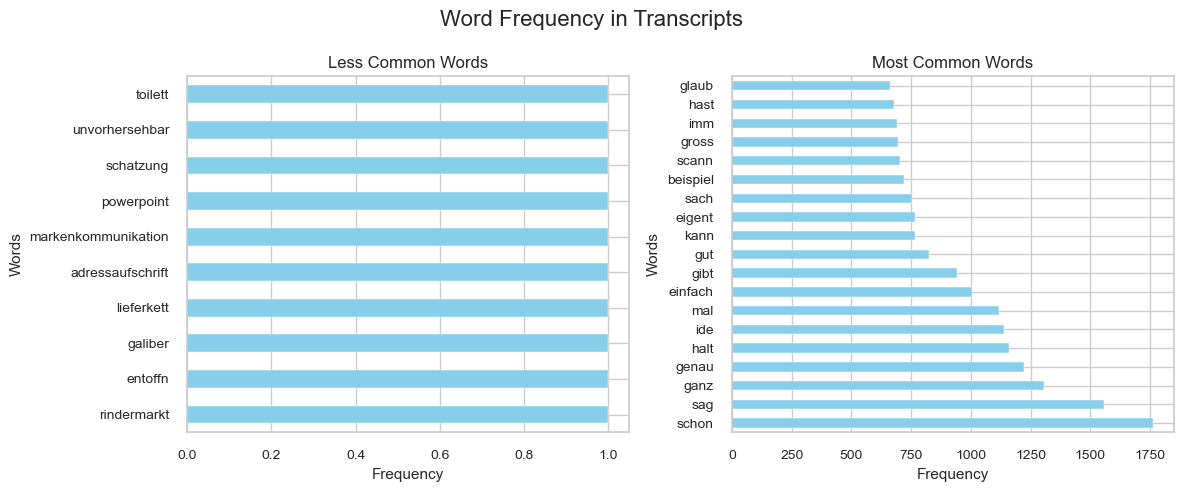

In [11]:
# Word Frequency of less common words
word_freq_less_common = pd.Series(' '.join(transcript_df['clean_final_transcript']).split()).value_counts()[-10:]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
word_freq_less_common.plot(kind='barh', color='skyblue')  # Use barh instead of bar
plt.title('Less Common Words')
plt.xlabel('Frequency')  # Invert x and y axis labels
plt.ylabel('Words')

# Word Frequency of most common words
word_freq_most_common = pd.Series(' '.join(transcript_df['clean_final_transcript']).split()).value_counts()[1:20]
plt.subplot(1, 2, 2)
word_freq_most_common.plot(kind='barh', color='skyblue')  # Use barh instead of bar
plt.title('Most Common Words')
plt.xlabel('Frequency')  # Invert x and y axis labels
plt.ylabel('Words')

plt.suptitle('Word Frequency in Transcripts', size=16)
plt.tight_layout()
plt.show()


#### `TF-IDF` Matrix Computation

In [12]:
# computation of the tf-idf matrix with the function compute_tfidf()
data_1 = transcript_df['clean_final_transcript']
tf_idf_1_df = compute_tfidf(data_1)

# Display the resulting DataFrame
tf_idf_1_df.head()

,aaa,aaa batteri,ab,ab abgeschnitt,ab aktuell,ab alt,ab amazon,ab asi,ab audio,ab ausbild,...,zwischenzeit ja,zwolf,zwolf laus,zwolf regierungsanzug,zwolfstundenzeit,zwolfstundenzeit verlor,zykl,zykl stund,zyklus,zyklus aufnehm
0,0.0,0.0,0.021539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.059731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.005763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.013142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Computing the Final Metric by Team

In [13]:
# Create the final DataFrame
final_1 = pd.DataFrame()

# Calculate the mean of each row, ignoring 0.0 values
mean_score_1 = tf_idf_1_df.replace(0.0, np.nan).mean(axis=1)

# Calculate the median of each row, ignoring 0.0 values
median_score_1 = tf_idf_1_df.replace(0.0, np.nan).median(axis=1)

# Calculate the top 10 percentile of each row, ignoring 0.0 values
top_10_score_1 = tf_idf_1_df.replace(0.0, np.nan).quantile(0.90, axis=1)

# Adding the "team_id" column for the transcript_df
final_1 = pd.DataFrame({
    'team_id': transcript_df['team_id'],
    'TF-IDF mean score': mean_score_1,
    'TF-IDF median score': median_score_1,
    'TF-IDF top 10% score': top_10_score_1
})

# Finally displaying the final metric per team
display(final_1)

,team_id,TF-IDF mean score,TF-IDF median score,TF-IDF top 10% score
0,1102,0.019432,0.020686,0.020686
1,1103,0.033381,0.039079,0.039079
2,1106,0.025194,0.028683,0.028683
3,1107,0.020673,0.022138,0.022138
4,1108,0.023923,0.025242,0.025242
...,...,...,...,...
111,2190,0.027932,0.032262,0.032262
112,2194,0.020665,0.021995,0.021995
113,2202,0.026311,0.029442,0.029442
114,2205,0.023163,0.024930,0.024930


### Idea 1.2 : `TF-IDF` Within the Team's Speakers

#### Creating a Dataframe with the `transcripts_speakers.csv` file

In [14]:
# Read the CSV file into a DataFrame
speaker_df = pd.read_csv(csv_file_path_2)

# Keep only the "clean_final_transcript" column
speaker_df = speaker_df[["team_id","speaker_id", "speaker_clean_final_transcript"]]

# Displaying the dataframe
display(speaker_df)

,team_id,speaker_id,speaker_clean_final_transcript
0,1102,SPEAKER_02,codefrauding erreichbar
1,1102,SPEAKER_03,ja konnt wollt gar
2,1102,SPEAKER_02,NaN
3,1102,SPEAKER_01,soll tim setz halb setz stimmt timebox drin
4,1102,SPEAKER_02,geschaftside konnt geschaftside
...,...,...,...
7208,2214,SPEAKER_03,natur sup abscann konnt lag konnt
7209,2214,SPEAKER_02,einfach sup gut gepasst programmiert meint sup...
7210,2214,SPEAKER_03,beschreib stimmt
7211,2214,SPEAKER_02,halt sach uberlegt halt mehr ahnung steht wiss...


#### Grouping by Speakers and Teams

In [15]:
# Drop rows with NaN values in the "speaker_clean_final_transcript" column
speaker_df = speaker_df.dropna(subset=['speaker_clean_final_transcript'])

# Group by "team_id" and "speaker_id" and concatenate transcripts
grouped_df = speaker_df.groupby(['team_id', 'speaker_id'])['speaker_clean_final_transcript'].agg(lambda x: ' '.join(x)).reset_index()

# Count the number of unique speakers for each team
speakers_count = grouped_df.groupby('team_id')['speaker_id'].nunique().reset_index()

# Rename the column to 'num_speakers'
speakers_count = speakers_count.rename(columns={'speaker_id': 'num_speakers_whisperX'})

# Calculate the mean of num_speakers_whisperX
mean_num_speakers_whisperX = speakers_count['num_speakers_whisperX'].mean()
print(f"Mean Number of Speakers: {mean_num_speakers_whisperX}")

# Display the resulting DataFrame sorted by 'num_speakers_whisperX'
display(speakers_count.sort_values(by='num_speakers_whisperX'))

Mean Number of Speakers: 3.3017241379310347


,team_id,num_speakers_whisperX
68,1210,1
33,1157,2
29,1152,2
26,1148,2
24,1146,2
...,...,...
50,1187,4
49,1186,4
48,1185,4
62,1203,4


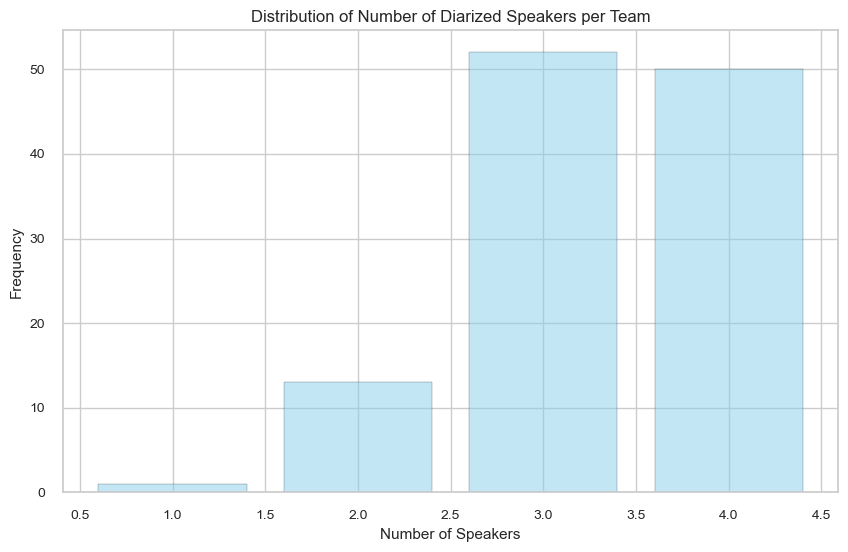

In [16]:
# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(speakers_count['num_speakers_whisperX'].value_counts().index, 
        speakers_count['num_speakers_whisperX'].value_counts().values,
        color='skyblue', edgecolor='black', alpha=0.5)
plt.title('Distribution of Number of Diarized Speakers per Team')
plt.xlabel('Number of Speakers')
plt.ylabel('Frequency')
plt.show()

#### `TF-IDF` Matrix Computation & Final Metric by Speakers

In [17]:
# Initialize an empty DataFrame to store the final results
final_2 = pd.DataFrame()

# Iterate over unique teams in grouped_df
for team_id in grouped_df['team_id'].unique():
    # Skip team with team_id 1210
    if team_id == 1210:  # PROBLEM TO REVIEW - ONLY 1 SPEAKERS
        continue

    # Filter data for the current team
    team_data = grouped_df[grouped_df['team_id'] == team_id]['speaker_clean_final_transcript']

    # Compute TF-IDF matrix for the current team
    tf_idf_team = compute_tfidf(team_data)

    # Calculate the mean of each row, ignoring 0.0 values
    mean_score = tf_idf_team.replace(0.0, np.nan).mean(axis=1)

    # Calculate the median of each row, ignoring 0.0 values
    median_score = tf_idf_team.replace(0.0, np.nan).median(axis=1)

    # Calculate the top 10 percentile of each row, ignoring 0.0 values
    top_10_score = tf_idf_team.replace(0.0, np.nan).quantile(0.90, axis=1)

    # Combine the scores with 'team_id' and 'speaker_id'
    team_results = pd.DataFrame({
        'team_id': team_id,
        'TF-IDF mean score': mean_score,
        'TF-IDF median score': median_score,
        'TF-IDF top 10% score': top_10_score
    })

    # Append the results for the current team to the final DataFrame
    final_2 = pd.concat([final_2, team_results], ignore_index=True)

# Display the resulting DataFrame
display(final_2)


,team_id,TF-IDF mean score,TF-IDF median score,TF-IDF top 10% score
0,1102,0.690478,0.690478,0.812437
1,1102,0.030566,0.026509,0.041801
2,1102,0.027316,0.023888,0.030495
3,1102,0.034491,0.031236,0.039875
4,1103,0.044715,0.041487,0.041487
...,...,...,...,...
377,2205,0.022575,0.018484,0.036967
378,2214,0.492228,0.513792,0.574580
379,2214,0.093247,0.095574,0.095574
380,2214,0.048508,0.043298,0.056573


#### Computing the Final Metric by Teams

In [18]:
# Group by 'team_id' and calculate the mean, median, and top 10% across speakers for each team
final_2_grouped = final_2.groupby('team_id').agg({
    'TF-IDF mean score': 'median',
    'TF-IDF median score': 'median',
    'TF-IDF top 10% score': 'median'
}).reset_index()

# Display the final dataframe
display(final_2_grouped)

,team_id,TF-IDF mean score,TF-IDF median score,TF-IDF top 10% score
0,1102,0.032529,0.028873,0.040838
1,1103,0.050071,0.046633,0.046633
2,1106,0.058853,0.058186,0.058186
3,1107,0.102554,0.098939,0.098939
4,1108,0.077397,0.078884,0.078884
...,...,...,...,...
110,2190,0.043875,0.040835,0.040835
111,2194,0.031370,0.027079,0.041188
112,2202,0.111041,0.113722,0.113722
113,2205,0.041739,0.039016,0.048258


### Comparison between the Two Implementations

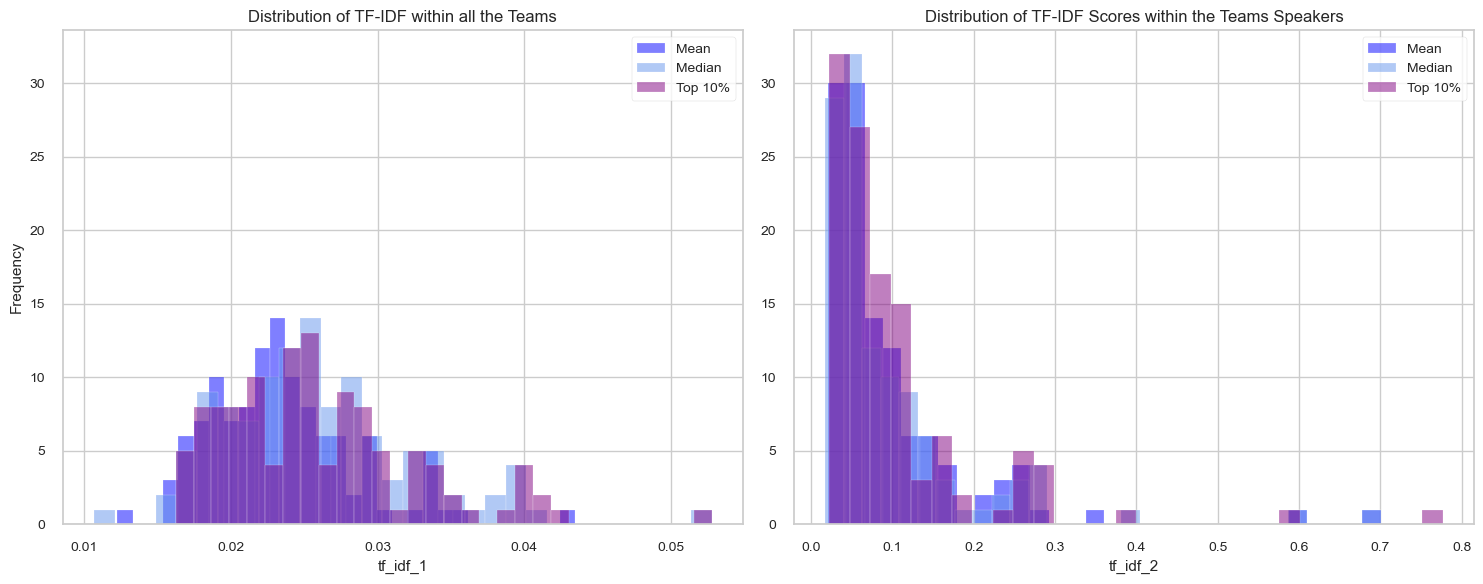

In [19]:
plt.figure(figsize=(15, 6))

# Plot histograms for final_1
plt.subplot(1, 2, 1)

# Plot histogram for TF-IDF score
plt.hist(final_1['TF-IDF mean score'], bins=30, alpha=0.5, label='Mean', color='blue')
plt.hist(final_1['TF-IDF median score'], bins=30, alpha=0.5, label='Median', color='cornflowerblue')
plt.hist(final_1['TF-IDF top 10% score'], bins=30, alpha=0.5, label='Top 10%', color='purple')

plt.title('Distribution of TF-IDF within all the Teams')
plt.xlabel('tf_idf_1')
plt.ylabel('Frequency')
plt.legend()

# Share y-axis for the second subplot
plt.subplot(1, 2, 2, sharey=plt.gcf().axes[0])

# Plot histograms for final_2_grouped
plt.hist(final_2_grouped['TF-IDF mean score'], bins=30, alpha=0.5, label='Mean', color='blue')
plt.hist(final_2_grouped['TF-IDF median score'], bins=30, alpha=0.5, label='Median', color='cornflowerblue')
plt.hist(final_2_grouped['TF-IDF top 10% score'], bins=30, alpha=0.5, label='Top 10%', color='purple')

plt.title('Distribution of TF-IDF Scores within the Teams Speakers')
plt.xlabel('tf_idf_2')
plt.ylabel('')  # No need to label the y-axis again
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()


## Benchmark : Speaker Diarization Error Rate (SDER)

Speaker Diarization Error Rate ($SDER$) is a crucial metric in speaker diarization, assessing the accuracy of the identified speakers compared to the ground truth. It combines the missed speakers rate ($MISS$) and false alarm rate ($FA$) to provide a comprehensive measure of diarization performance. Let $M$ represent the margin and $T$ represent the total number of ground truth speakers. The $SDER$ is calculated using the formula:

$$SDER = \frac{MISS + FA}{T}$$

The counts of missed speakers ($MISS$), false alarms ($FA$) and the total number of ground truth speakers ($T$) are computed as follows:

$$T = \sum_{i=1}^{N} \text{TS}_i$$

$$MISS = \sum_{i=1}^{N} 1_{(\text{DS}_i + M < \text{TS}_i)}$$

$$FA = \sum_{i=1}^{N} 1_{(\text{DS}_i - M > \text{TS}_i)}$$

where:
- $N$ is the number of teams.
- $\text{DS}_i$ is the count of diarized speakers for team $i$.
- $\text{TS}_i$ is the count of true speakers for team $i$.

The metrics are implemented in the function `diarization_metrics()`in the helpers.py file.

*Note:* see the reference [link](https://www.colips.org/conferences/iscslp2022/Proceedings/papers/ISCSLP2022_P126.pdf).


### True Team Members - Dataframe Generation

In [20]:
# Create DataFrame by reading the CSV file
df = pd.read_csv(dataset_path, sep=';')

# Replace the ',' by '.' and convert it to float
df[['exp_depth', 'task_duration']] = df[['exp_depth', 'task_duration']].apply(lambda x: x.str.replace(',', '.').astype(float))

# Display the DataFrame sorted by 'team_ID' in ascending order
display(df.sort_values(by='team_id', ascending=True))

,team_id,number_ideas,team_members,exp_breadth,exp_depth,team_spirit,task_duration,startup_age,startup_ind
29,1102,10,3,4,2.7,0,1662.2,3,54
68,1103,7,2,6,3.5,0,1430.6,2,54
11,1106,10,2,3,2.0,0,1695.2,3,52
64,1107,4,2,6,4.5,0,1204.8,3,72
24,1108,5,2,3,1.0,0,740.5,3,51
...,...,...,...,...,...,...,...,...,...
95,2190,9,3,9,1.0,1,1504.1,2,54
36,2194,9,2,4,12.0,1,1850.6,4,54
51,2202,9,2,5,2.0,1,1631.2,1,54
72,2205,16,2,6,1.5,1,1773.7,2,33


### WhisperX :

In [21]:
# Merge the DataFrames based on the 'team_id' column
whisperx_df = df.merge(speakers_count, on='team_id', how='left')

# Rename the 'speaker_id' column to 'num_speakers_whisperX'
whisperx_df = whisperx_df.rename(columns={'speaker_id': 'num_speakers_whisperX'})

# Print the diarization metrics for margin 0 and 1
print("\n- Metrics for margin = 0:\n ")
diarization_metrics(whisperx_df['num_speakers_whisperX'], whisperx_df['team_members'], margin=0)
print("\n- Metrics for margin = 1:\n ")
diarization_metrics(whisperx_df['num_speakers_whisperX'], whisperx_df['team_members'], margin=1)


- Metrics for margin = 0:
 
Missed Speakers Rate: 0.0246
False Alarm Rate: 0.2852
Speaker Diarization Error Rate (SDER): 0.3099

- Metrics for margin = 1:
 
Missed Speakers Rate: 0.0035
False Alarm Rate: 0.1021
Speaker Diarization Error Rate (SDER): 0.1056


### Pyannote (rttms) :

In [22]:
# Call the function with the specified folder path
pyannote_data = process_rttm_files(pyannote_folder_path)

# Convert the 'team_id' column to int64
pyannote_data['team_id'] = pyannote_data['team_id'].astype(int)

# Merge the dataframes
pyannote_df = pd.merge(df, pyannote_data[['team_id', 'num_speakers_pyannote']], on='team_id', how='left')

# Display the resulting DataFrame
display(pyannote_df)

# Print the diarization metrics for margin 0 and 1
print("\n- Metrics for margin = 0:\n ")
diarization_metrics(pyannote_df['num_speakers_pyannote'], pyannote_df['team_members'], margin=0)
print("\n- Metrics for margin = 1:\n ")
diarization_metrics(pyannote_df['num_speakers_pyannote'], pyannote_df['team_members'], margin=1)

,team_id,number_ideas,team_members,exp_breadth,exp_depth,team_spirit,task_duration,startup_age,startup_ind,num_speakers_pyannote
0,1127,9,2,1,3.5,0,1773.9,4,51,5
1,2182,25,2,1,8.0,1,1927.5,1,42,5
2,1180,3,2,2,20.0,0,627.0,1,62,3
3,2149,3,2,2,1.5,1,1411.0,1,31,5
4,2119,16,3,2,8.3,1,1555.7,4,51,5
...,...,...,...,...,...,...,...,...,...,...
111,2165,9,5,10,2.8,1,1689.7,1,54,5
112,1136,9,2,11,5.5,0,3736.8,2,54,4
113,2133,15,4,13,8.8,1,1422.9,4,54,5
114,1114,11,2,13,16.0,0,1668.0,6,54,4



- Metrics for margin = 0:
 
Missed Speakers Rate: 0.0106
False Alarm Rate: 0.3662
Speaker Diarization Error Rate (SDER): 0.3768

- Metrics for margin = 1:
 
Missed Speakers Rate: 0.0000
False Alarm Rate: 0.2606
Speaker Diarization Error Rate (SDER): 0.2606


### Deepgram (jsons) :

In [23]:
# Call the function with the specified folder path
deepgram_data = process_deepgram_files(deepgram_folder_path)

# Convert the 'team_id' column to int64
deepgram_data['team_id'] = deepgram_data['team_id'].astype(int)

# Merge the dataframes
deepgram_df = pd.merge(df, deepgram_data[['team_id', 'num_speakers_deepgram']], on='team_id', how='left')

# Display the resulting DataFrame
display(deepgram_df)

# Print the diarization metrics for margin 0 and 1
print("\n- Metrics for margin = 0:\n ")
diarization_metrics(deepgram_df['num_speakers_deepgram'], deepgram_df['team_members'], margin=0)
print("\n- Metrics for margin = 1:\n ")
diarization_metrics(deepgram_df['num_speakers_deepgram'], deepgram_df['team_members'], margin=1)

,team_id,number_ideas,team_members,exp_breadth,exp_depth,team_spirit,task_duration,startup_age,startup_ind,num_speakers_deepgram
0,1127,9,2,1,3.5,0,1773.9,4,51,3
1,2182,25,2,1,8.0,1,1927.5,1,42,4
2,1180,3,2,2,20.0,0,627.0,1,62,3
3,2149,3,2,2,1.5,1,1411.0,1,31,3
4,2119,16,3,2,8.3,1,1555.7,4,51,4
...,...,...,...,...,...,...,...,...,...,...
111,2165,9,5,10,2.8,1,1689.7,1,54,5
112,1136,9,2,11,5.5,0,3736.8,2,54,3
113,2133,15,4,13,8.8,1,1422.9,4,54,4
114,1114,11,2,13,16.0,0,1668.0,6,54,4



- Metrics for margin = 0:
 
Missed Speakers Rate: 0.0141
False Alarm Rate: 0.3275
Speaker Diarization Error Rate (SDER): 0.3415

- Metrics for margin = 1:
 
Missed Speakers Rate: 0.0035
False Alarm Rate: 0.1444
Speaker Diarization Error Rate (SDER): 0.1479


## Idea 2 : Speaking Time Concentration

### Creating a Dataframe with the `speaking_time.csv` file

In [24]:
# Read the CSV file into a DataFrame
data = pd.read_csv(csv_file_path_3)

# Display the DataFrame$
display(data)

,length,speaker,Team_ID
0,6.322,SPEAKER_02,1102
1,1.681,SPEAKER_02,1102
2,3.522,SPEAKER_03,1102
3,2.401,SPEAKER_03,1102
4,1.820,SPEAKER_03,1102
...,...,...,...
49583,6.241,SPEAKER_02,2214
49584,4.181,SPEAKER_02,2214
49585,2.941,SPEAKER_03,2214
49586,2.461,SPEAKER_03,2214


### Idea 2.1 : Compute the Dominance Value by Team

When the leader dominates the meeting, the leader's speaking time is probably more than that of the other guy. The leader could help the team members generate ideas. The leader will likely attract more attention and have higher visibility during the meeting. High visibility means a leader's ideas are more likely to be heard and considered by other participants. Leaders usually have the ability to set the agenda and shape the direction of the discussion, which may guide the overall focus of the meeting, making the idea generated efficiently. The leader could increase the team member's confidence, which can inspire others to express their ideas.

But, vice versa, the leader harms the idea generation. When a leader dominates the conversation, there is a risk of suppressing other team members' ideas. This dominance may discourage introverted team members from sharing their unique perspectives and ideas, limiting the diversity of thought. Conversely, a bad leader could create an environment where team members fear negative consequences for challenging the leader's ideas or offering opinions. This fear may decrease creativity and discourage the expression of unconventional or critical viewpoints.
Based on the argument above, we use a metric named "dominance" to quantify the leadership domination within a conversation. "Dominance" is formulated by subtracting the normalized total speaking time of all other speakers from the total speaking time of the leader, who speaks longest among the speakers.

$$    Dominance = t_{1:k} - \frac{\sum_{i=2}^{k}t_{i:k}}{k-1} $$
where k is the number of speakers in a conversation and $t_{1:k}, t_{2:k},...,t_{k:k}$ are a list of the total speaking time of each speaker with $t_{1:k}>t_{2:k}>...>t_{k:k}$.

Since we are not clear whether "dominance" could have a positive or negative influence on the number of idea generations, The relationship between "dominance" and the number of ideas generations might not be linear, so we will test both dominance and the square of dominance as the independent variables when we do the final regression.

In [25]:
# Computing the dominance values (grouped by team) and normalizing (min-max) them (see helpers.py)
dominance = normalize(data.groupby('Team_ID').apply(dominance))

# Convert the Series to a DataFrame and reset the index
dominance = dominance.reset_index()

# Rename the column if needed
dominance = dominance.rename(columns={0: 'dominance', 'Team_ID': 'team_id'})
dominance['team_id'] = dominance['team_id'].astype(int)

# Displaying the results
display(dominance)

,team_id,dominance
0,1102,0.073892
1,1103,0.045734
2,1106,0.326363
3,1107,0.355314
4,1108,0.194238
...,...,...
111,2190,0.126528
112,2194,0.284848
113,2202,0.081770
114,2205,0.196771


### Idea 2.2 : Compute the Skewness Value by Team

Skewness in the distribution of speaking time indicates an asymmetry in how time is allocated during the conversation. Positive skewness means most of the continuous speaking time will be short, and only a few of the continuous speaking time will be way longer than the other continuous speaking time. Same for negative skewness.

Suppose the distribution of continuous speaking time is positive skewness. In that case, it will lead to high-frequency dialogue, facilitated by shorter speaking times and can lead to more interactions and collisions of ideas. The rapid exchange of thoughts and perspectives may spark new connections and insights, contributing to a more creative idea-generation process. In addition, Shorter speaking times may prompt participants to express their ideas in concise and impactful messages. This efficiency in communication could facilitate the generation of ideas, allowing the most relevant and promising concepts to emerge and be further developed. However, shorter speaking times might limit the depth to which ideas can be explored, leading to a more surface-level discussion. The lack of extended discussion time may prevent participants from delving into the complexities and potential challenges associated with their ideas.

As for negative skewness distribution, longer speaking times may allow for more in-depth exploration of ideas, allowing participants to delve into complexities. Participants can elaborately discuss their concepts, potentially leading to a more comprehensive understanding of proposed ideas. However, extended speaking times may slow down the pace of the discussion, potentially surpassing the generation of a diverse range of ideas within a limited timeframe. Participants may spend more time on individual contributions, reducing the overall number of ideas explored during the meeting.


$$    Skewness = \frac{n}{(n-1)(n-2)} \sum_{i=1}^{n} \left( \frac{t_i - \bar{t}}{s} \right)^3 $$

where $t_1, t_2... t_n$ is the list of continuous speaking times, and n is the number of continuous speaking times during the conversation. And $\bar{x}$ and s are the mean and standard variance of continuous speaking time $t_i$, respectively. Example of the different skewness distribution [link](https://www.biologyforlife.com/skew.html):


![skewness](./img/skewness.png)

In [26]:
# If 'length' is not numeric, convert it to numeric
data['length'] = pd.to_numeric(data['length'], errors='coerce')

# Computing the skewness of the continuous speaking time (grouped by team)
skewness = data.groupby('Team_ID')['length'].skew()

# Convert the Series to a DataFrame and reset the index
skewness = skewness.reset_index()

# Rename the column if needed
skewness = skewness.rename(columns={'length': 'skewness', 'Team_ID': 'team_id'})
skewness['team_id'] = skewness['team_id'].astype(int)

# Displaying the results
display(skewness)

,team_id,skewness
0,1102,2.066480
1,1103,1.856122
2,1106,1.478711
3,1107,1.484690
4,1108,2.284144
...,...,...
111,2190,1.941546
112,2194,1.970178
113,2202,1.579065
114,2205,1.559695


## Negative Binomial Regression as Prediction Model

To compare the five different models resulting from the inclusion of our new metrics, we adopted the same assumption as presented in the lab draft paper, utilizing a negative binomial regression as the predictive model for the number of ideas generated. We report the $Pseudo R^2$, $AIC$, and $log-Likelihood$ to provide comparable metrics. Additionally, for all the models, we present 114 observations instead of 116 (removal of $NaN$ values), and we also include ventures' industry dummies.

### Final Dataset with the New Metrics

In [27]:
# Merging the final metrcis from the DataFrame : Dominance, Skewness, final_1, and final_2_grouped 
df_final = pd.merge(df, dominance[['team_id', 'dominance']], on='team_id', how='left')
df_final = pd.merge(df_final, skewness[['team_id', 'skewness']], on='team_id', how='left')
df_final = pd.merge(df_final, final_1[['team_id', 'TF-IDF top 10% score']], on='team_id', how='left')
df_final = pd.merge(df_final, final_2_grouped[['team_id', 'TF-IDF top 10% score']], on='team_id', how='left')

# Renaming the two TF-IDF columns for clarity 
df_final = df_final.rename(columns={'TF-IDF top 10% score_x': 'tf_idf_1'})
df_final = df_final.rename(columns={'TF-IDF top 10% score_y': 'tf_idf_2'})

# Transform the startup_ind into dummy variables
df_final = pd.get_dummies(df_final, columns=['startup_ind'], prefix='startup_ind', drop_first=True)

# Create a column which contains the squared dominance metric
df_final['dominance_square']=df_final['dominance']**2

# Display the final DataFrame
display(df_final)

# Print all columns of df_final
print(df_final.columns)

,team_id,number_ideas,team_members,exp_breadth,exp_depth,team_spirit,task_duration,startup_age,dominance,skewness,...,startup_ind_42,startup_ind_44,startup_ind_45,startup_ind_51,startup_ind_52,startup_ind_54,startup_ind_62,startup_ind_71,startup_ind_72,dominance_square
0,1127,9,2,1,3.5,0,1773.9,4,0.186151,1.303991,...,False,False,False,True,False,False,False,False,False,0.034652
1,2182,25,2,1,8.0,1,1927.5,1,0.147899,1.491576,...,True,False,False,False,False,False,False,False,False,0.021874
2,1180,3,2,2,20.0,0,627.0,1,0.031375,1.729037,...,False,False,False,False,False,False,True,False,False,0.000984
3,2149,3,2,2,1.5,1,1411.0,1,0.000000,2.194363,...,False,False,False,False,False,False,False,False,False,0.000000
4,2119,16,3,2,8.3,1,1555.7,4,0.290161,1.805104,...,False,False,False,True,False,False,False,False,False,0.084193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2165,9,5,10,2.8,1,1689.7,1,0.239960,1.576871,...,False,False,False,False,False,True,False,False,False,0.057581
112,1136,9,2,11,5.5,0,3736.8,2,0.281457,1.787540,...,False,False,False,False,False,True,False,False,False,0.079218
113,2133,15,4,13,8.8,1,1422.9,4,0.049169,1.973296,...,False,False,False,False,False,True,False,False,False,0.002418
114,1114,11,2,13,16.0,0,1668.0,6,0.543066,1.404746,...,False,False,False,False,False,True,False,False,False,0.294921


Index(['team_id', 'number_ideas', 'team_members', 'exp_breadth', 'exp_depth',
       'team_spirit', 'task_duration', 'startup_age', 'dominance', 'skewness',
       'tf_idf_1', 'tf_idf_2', 'startup_ind_32', 'startup_ind_33',
       'startup_ind_42', 'startup_ind_44', 'startup_ind_45', 'startup_ind_51',
       'startup_ind_52', 'startup_ind_54', 'startup_ind_62', 'startup_ind_71',
       'startup_ind_72', 'dominance_square'],
      dtype='object')


In [28]:
# Removing all the Nan values
df_clean = df_final.dropna()

# Convert boolean columns to numeric (0 or 1)
boolean_columns = ['startup_ind_32', 'startup_ind_33', 'startup_ind_42', 'startup_ind_44', 'startup_ind_45', 
                'startup_ind_51', 'startup_ind_52', 'startup_ind_54', 'startup_ind_62', 'startup_ind_71', 'startup_ind_72']
df_clean[boolean_columns] = df_clean[boolean_columns].astype(int)

# Normalizing the selected features using the same Min-Max scaling 
selected_features = ['team_members', 'exp_breadth', 'exp_depth', 'team_spirit', 'task_duration', 'startup_age', 
                    'dominance', 'skewness', 'tf_idf_1', 'tf_idf_2', 'dominance_square']
df_clean[selected_features] = normalize(df_clean[selected_features])
display(df_clean)

,team_id,number_ideas,team_members,exp_breadth,exp_depth,team_spirit,task_duration,startup_age,dominance,skewness,...,startup_ind_42,startup_ind_44,startup_ind_45,startup_ind_51,startup_ind_52,startup_ind_54,startup_ind_62,startup_ind_71,startup_ind_72,dominance_square
0,1127,9,0.000000,0.000000,0.175,0.0,0.368802,0.500000,0.186151,0.075704,...,0,0,0,1,0,0,0,0,0,0.034652
1,2182,25,0.000000,0.000000,0.400,1.0,0.418194,0.000000,0.147899,0.191305,...,1,0,0,0,0,0,0,0,0,0.021874
2,1180,3,0.000000,0.083333,1.000,0.0,0.000000,0.000000,0.031375,0.337641,...,0,0,0,0,0,0,1,0,0,0.000984
3,2149,3,0.000000,0.083333,0.075,1.0,0.252106,0.000000,0.000000,0.624401,...,0,0,0,0,0,0,0,0,0,0.000000
4,2119,16,0.333333,0.083333,0.415,1.0,0.298637,0.500000,0.290161,0.384517,...,0,0,0,1,0,0,0,0,0,0.084193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2165,9,1.000000,0.750000,0.140,1.0,0.341726,0.000000,0.239960,0.243868,...,0,0,0,0,0,1,0,0,0,0.057581
112,1136,9,0.000000,0.833333,0.275,0.0,1.000000,0.166667,0.281457,0.373694,...,0,0,0,0,0,1,0,0,0,0.079218
113,2133,15,0.666667,1.000000,0.440,1.0,0.255933,0.500000,0.049169,0.488167,...,0,0,0,0,0,1,0,0,0,0.002418
114,1114,11,0.000000,1.000000,0.800,0.0,0.334748,0.833333,0.543066,0.137795,...,0,0,0,0,0,1,0,0,0,0.294921


### Feature Matrix Generation 

In this section, we outline the process of creating and exploring feature matrices derived from the original dataset (`X`). The feature matrices are constructed by incorporating additional columns, and their dimensions are displayed for reference. The resulting feature matrices are denoted as `X`, `X_1`, `X_2`, `X_3`, and `X_4`, corresponding to the original matrix and its variations.

In [29]:
# Specify the dependent variable ('number_ideas') and the independent ones 
y = 'number_ideas'
X_columns = ['team_members', 'exp_breadth', 'exp_depth', 'team_spirit', 'task_duration', 'startup_age', 'startup_ind_32', 
    'startup_ind_33', 'startup_ind_42', 'startup_ind_44', 'startup_ind_45', 'startup_ind_51', 'startup_ind_52', 
    'startup_ind_54', 'startup_ind_62', 'startup_ind_71', 'startup_ind_72']

# Original feature matrix
X = df_clean[X_columns]

# List of additional columns for feature matrices we only select tf_idf_2
additional_columns = [
    ['tf_idf_2'],
    ['skewness'],
    ['dominance', 'dominance_square'],
    ['tf_idf_2', 'skewness', 'dominance', 'dominance_square']  
]

# Create feature matrices using a loop and dropping all the NaN values
feature_matrices_X = [X] + [X.copy().join(df_final[cols]) for cols in additional_columns]

# List of matrix names corresponding to each feature matrix
matrix_names_X = ['X_1', 'X_2', 'X_3', 'X_4', 'X_5']

# Display the first few rows of each feature matrix
for idx, X_i in enumerate(feature_matrices_X):
    print(f"Shape of {matrix_names_X[idx]}: {X_i.shape}\n")

Shape of X_1: (114, 17)

Shape of X_2: (114, 18)

Shape of X_3: (114, 18)

Shape of X_4: (114, 19)

Shape of X_5: (114, 21)



### Negative Binomial Regression Model

In [30]:
def run_negative_binomial_regression(X, y, data):
    # Add a constant term to the independent variables (required for statsmodels)
    X = sm.add_constant(X)
    y = data[y]

    # Fit the negative binomial regression model
    nb_model = sm.NegativeBinomial(y, X).fit()
    # nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
    # nb_model = sm.OLS(y,X).fit()

    # Calculate AIC and BIC
    ll_full = nb_model.llf
    n_params = len(nb_model.params)
    aic = -2 * ll_full + 2 * n_params
    bic = -2 * ll_full + n_params * np.log(n_params)

    # Print the regression results
    print(f"Dependent Variable: {y.name}")
    print(f"Independent Variables: {X.columns.tolist()}")
    print(nb_model.summary())
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")

In [31]:
# Run the negative binomial regression for each set of independent variables
for idx, X_i in enumerate(feature_matrices_X):
    print(f"Running regression for {matrix_names_X[idx]}:")
    run_negative_binomial_regression(X_i, y, df_clean)

    # Separate regression results for different feature matrices
    print('\n' + '=' * 80 + '\n')  

Running regression for X_1:
Optimization terminated successfully.
         Current function value: 2.774478
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Dependent Variable: number_ideas
Independent Variables: ['const', 'team_members', 'exp_breadth', 'exp_depth', 'team_spirit', 'task_duration', 'startup_age', 'startup_ind_32', 'startup_ind_33', 'startup_ind_42', 'startup_ind_44', 'startup_ind_45', 'startup_ind_51', 'startup_ind_52', 'startup_ind_54', 'startup_ind_62', 'startup_ind_71', 'startup_ind_72']
                     NegativeBinomial Regression Results                      
Dep. Variable:           number_ideas   No. Observations:                  114
Model:               NegativeBinomial   Df Residuals:                       96
Method:                           MLE   Df Model:                           17
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                 0.03750
Time:                        11:27:07   Log-Likeli

Optimization terminated successfully.
         Current function value: 2.754714
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Dependent Variable: number_ideas
Independent Variables: ['const', 'team_members', 'exp_breadth', 'exp_depth', 'team_spirit', 'task_duration', 'startup_age', 'startup_ind_32', 'startup_ind_33', 'startup_ind_42', 'startup_ind_44', 'startup_ind_45', 'startup_ind_51', 'startup_ind_52', 'startup_ind_54', 'startup_ind_62', 'startup_ind_71', 'startup_ind_72', 'skewness']
                     NegativeBinomial Regression Results                      
Dep. Variable:           number_ideas   No. Observations:                  114
Model:               NegativeBinomial   Df Residuals:                       95
Method:                           MLE   Df Model:                           18
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                 0.04436
Time:                        11:27:07   Log-Likelihood:           

## Features Importance trough Random Forest Classification

**Assumption:** Given the limited dataset of only 116 distinct teams (114 without the `Nan` values), which may not provide ample data for our algorithm, we found it valuable to categorize them into classess based on the quantity of ideas they generate. This approach facilitates supervised learning, allowing us to develop a model that predicts the most accurate outcome class based on the team's features. First we will remove all thee `Nan` values and see the distribution of the number of idea through all the teams : 

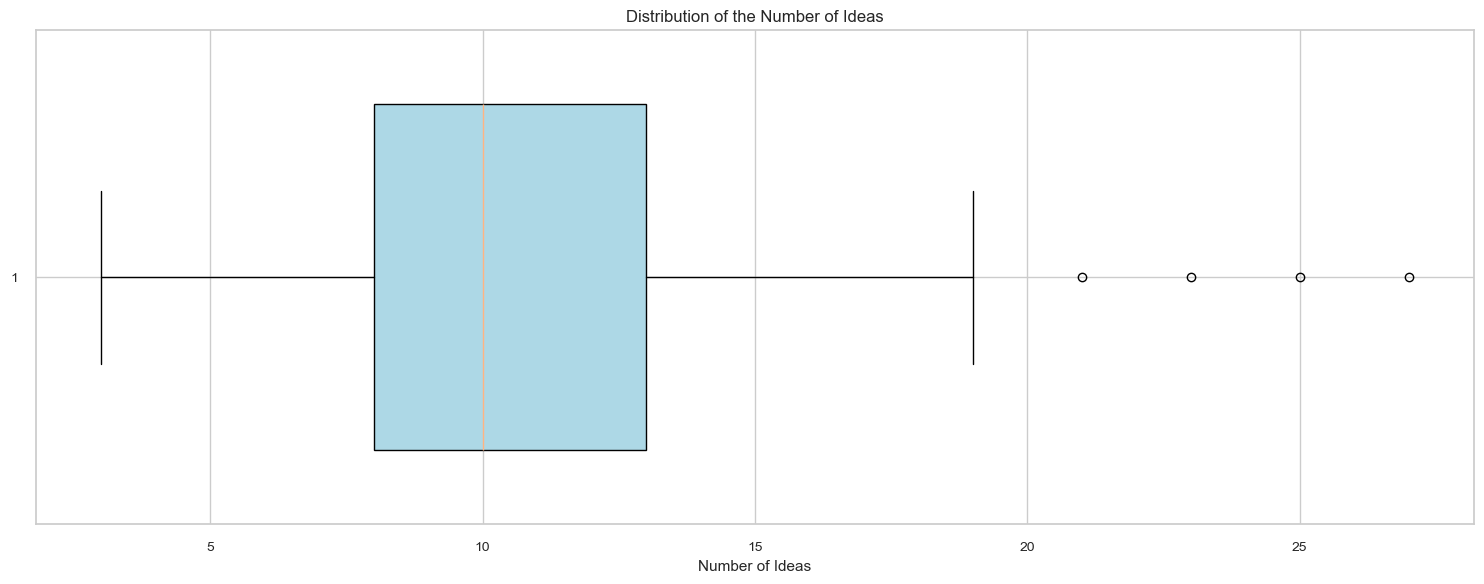

In [32]:
# Create a figure with Matplotlib
plt.figure(figsize=(15, 6))

# Plot a boxplot for better representation of the distribution
plt.boxplot(df_clean['number_ideas'], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Set plot labels and title
plt.title('Distribution of the Number of Ideas')
plt.xlabel('Number of Ideas')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

### 1) Strict Classification

In this first classification, the strict classes are defined as follows:

- **Low** class : number of ideas generates from 0 to 9
- **Medium** class : number of ideas generates from 10 to 18
- **High** class : number of ideas generates from 19 to 27

In [33]:
def strict_classification(number_ideas_column):
    def classify(a):
        if a <= 9 and a >= 0:
            return 'low'
        elif a <= 18 and a >= 10:
            return 'medium'
        else:
            return 'high'

    # Apply the classification function to create a 'class' column
    return number_ideas_column.apply(classify)

# Apply the functions to the 'number_ideas' column and display the result
df_clean['strict_class'] = strict_classification(df_clean['number_ideas'])
display(df_clean.groupby('strict_class').count()['team_id'])

strict_class
high       5
low       47
medium    62
Name: team_id, dtype: int64

### 2) Quantile Classification

In this second classification, the classes are defined using the quantiles to better fit the data distribution. We use the the quantiles list [0, 1/3, 2/3, 1] which corresponds to the following ranges:

- **Low** class : values up to approximately 33% of the data
- **Medium** class :values from approximately 33% to 66% of the data
- **High** class : values from approximately 66% to 100% of the data

In [34]:
def quantile_classification(number_ideas_column, class_labels=['low', 'medium', 'high']):
    # Create quantiles for three classes
    quantiles = [0, 1/3, 2/3, 1]

    # Assign classes based on quantiles
    quantile_class = pd.qcut(number_ideas_column, q=quantiles, labels=class_labels)
    
    # Display the quantile and the corresponding number of generated ideas
    quantile_ranges = pd.qcut(number_ideas_column, q=quantiles, retbins=True)[1]
    for i in range(len(quantile_ranges) - 1):
        quantile_count = quantile_class[quantile_class == class_labels[i]].shape[0]
        print(f'{class_labels[i].capitalize()} quantile range: {quantile_ranges[i]} - {quantile_ranges[i + 1]} ideas (Number of teams: {quantile_count})')
    
    return quantile_class

# Create an empty column 'quantile_class' in df_clean
df_clean['quantile_class'] = pd.Series(dtype='category')

# Apply the function to the 'number_ideas' column
df_clean['quantile_class'] = quantile_classification(df_clean['number_ideas'])

Low quantile range: 3.0 - 9.0 ideas (Number of teams: 47)
Medium quantile range: 9.0 - 13.0 ideas (Number of teams: 39)
High quantile range: 13.0 - 27.0 ideas (Number of teams: 28)


### Feature Matrix Generation 

In this section, we outline the process of creating and exploring feature matrices derived from the original dataset (`Xc`). The feature matrices are constructed with the same method as before but this time we don't tale into account the `boolean` columns `startup_ind` (the classifier doesn't work with them). The resulting feature matrices are denoted as `Xc`, `Xc_1`, `Xc_2`, `Xc_3`, and `Xc_4`, corresponding to the original matrix and its variations.

In [35]:
# Specify the dependent variable ('number_ideas') and the independent ones 
Xc_columns = ['team_members', 'exp_breadth', 'exp_depth', 'team_spirit', 'task_duration', 'startup_age']

# Original feature matrix
Xc = df_clean[Xc_columns]

# Create feature matrices using a loop and dropping all the NaN values
feature_matrices_Xc = [Xc] + [Xc.copy().join(df_final[cols]) for cols in additional_columns]

# List of matrix names corresponding to each feature matrix
matrix_names_Xc = ['Xc_1', 'Xc_2', 'Xc_3', 'Xc_4', 'Xc_5']

# Display the first few rows of each feature matrix
for idx, Xc_i in enumerate(feature_matrices_Xc):
    print(f"Shape of {matrix_names_Xc[idx]}: {Xc_i.shape}\n")

Shape of Xc_1: (114, 6)

Shape of Xc_2: (114, 7)

Shape of Xc_3: (114, 7)

Shape of Xc_4: (114, 8)

Shape of Xc_5: (114, 10)



### Model Evaluation for Target Variables

In this analysis, we delve into the evaluation of predictive models, specifically focusing on the `Random Forest Classifier`. The assessment is carried out for two distinct target variables: `strict_class` and `quantile_class`. The models are evaluated across diverse feature matrices previously implemented, exploring their performance and robustness in predicting the given target variables. Illustration of `Random Forest Classifier` method [link](https://medium.com/@mrmaster907/introduction-random-forest-classification-by-example-6983d95c7b91):

![alt text](https://medium.com/@mrmaster907/introduction-random-forest-classification-by-example-6983d95c7b91)

1. **Train Test Split:**
We implement a robust train-test split methodology to ensure the generalizability of our models. Utilizing the `train_test_split` function from `scikit-learn`, we randomly divide the dataset into training and test sets `test_size=0.2`. This process is repeated across multiple folds, incorporating stratification to maintain the distribution of target classes. By doing so, we guard against overfitting and obtain a more reliable assessment of our models' performance on unseen data.

2. **Hyperparameter Tuning:**
Hyperparameter tuning is essential for optimizing the performance of our Random Forest models. Leveraging the `GridSearchCV` function from `scikit-learn`, we conduct an exhaustive search over a predefined hyperparameter grid. The grid encompasses key parameters such as the number of trees (`n_estimators`), maximum depth of the trees (`max_depth`), minimum samples required to split an internal node (`min_samples_split`), and minimum samples required to be at a leaf node (`min_samples_leaf`). The cross-validated grid search helps us identify the best combination of hyperparameters, enhancing the model's predictive capability.

3. **F1 Score:**
We report the F1 Score as the primary metric for evaluating classifier performance. The F1 Score strikes a balance between precision and recall, providing a single value that conveys the model's accuracy, especially in the context of imbalanced datasets. By using the weighted average F1 Score, we account for potential class imbalances and ensure a comprehensive evaluation of the model's ability to correctly classify instances across all classes.

4. **Tree Example:**
In addition to numerical metrics, we offer a visual representation of the model's decision-making process by providing an example of a decision tree. This tree is generated using the best sets of hyperparameters determined during the tuning process. Visualizing a decision tree aids in understanding how the model partitions the feature space and makes predictions. 



Best hyperparameters for Xc_1 - strict_class:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
F1 score for Xc_1 - strict_class: 0.5574841037979034


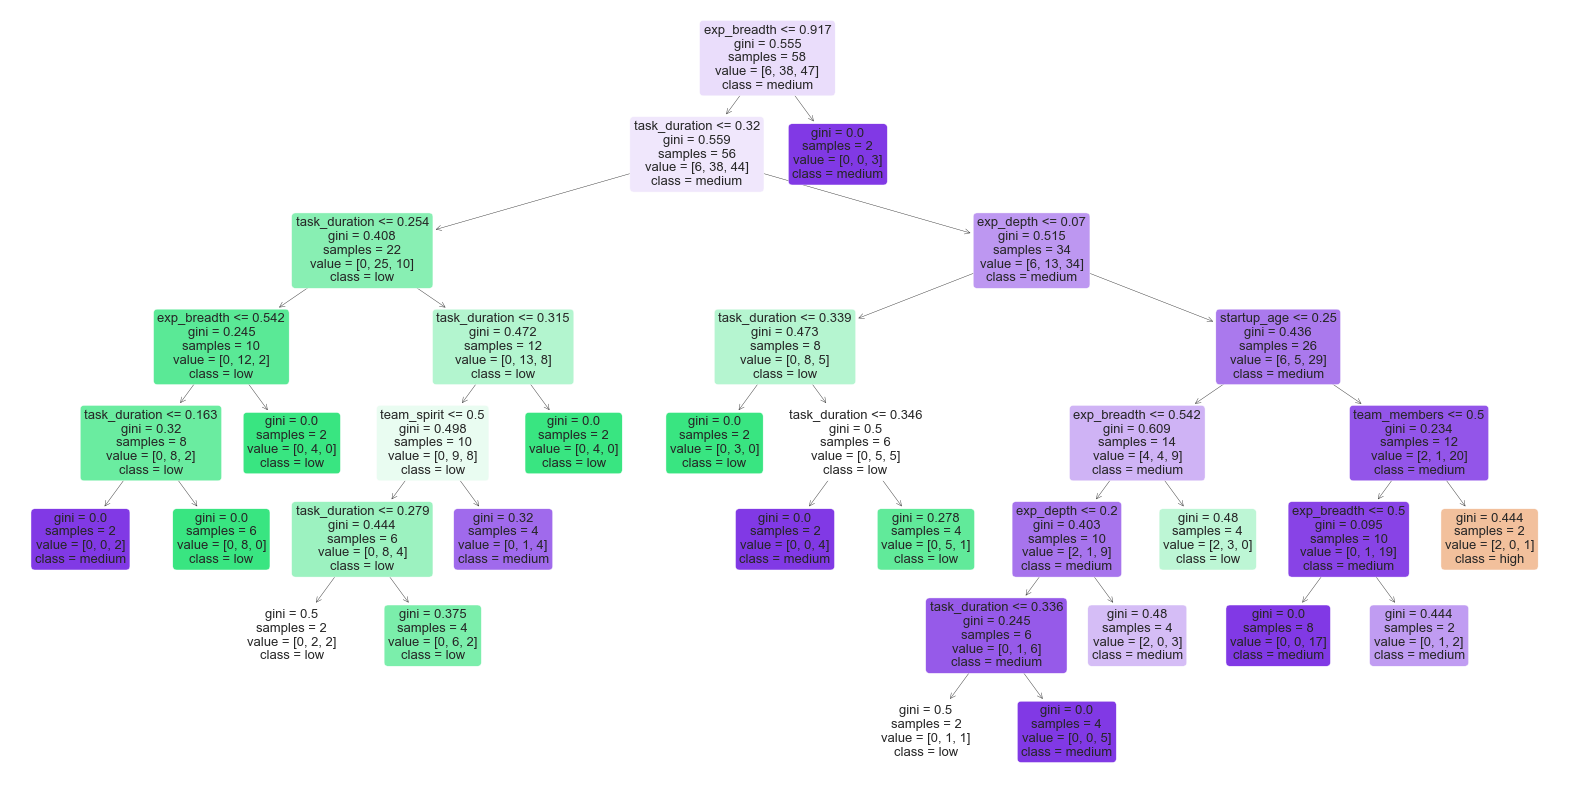


Best hyperparameters for Xc_1 - quantile_class:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
F1 score for Xc_1 - quantile_class: 0.2663615560640732

Best hyperparameters for Xc_2 - strict_class:
{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
F1 score for Xc_2 - strict_class: 0.46480331262939956

Best hyperparameters for Xc_2 - quantile_class:
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
F1 score for Xc_2 - quantile_class: 0.33126293995859213

Best hyperparameters for Xc_3 - strict_class:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
F1 score for Xc_3 - strict_class: 0.5573913043478261

Best hyperparameters for Xc_3 - quantile_class:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 50}
F1 score for Xc_3 - quantile_class: 0.13610586011342155

Best hyperparameters for Xc_4 - strict_class:
{'max_

In [42]:
# Define target variables
target_variables = ['strict_class', 'quantile_class']

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],         # number of trees
    'max_depth': [None, 5, 10, 15],         # maximum depth of the tree
    'min_samples_split': [2, 3, 5, 7, 10],  # minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4, 5]     # minimum number of samples required to be at a leaf node
}

# Initialize an empty list to accumulate results for feature importances
feature_importance_results = []

# Initialize an empty list to accumulate results for F1 Score
f1_score_results = []

# Custom color palette
custom_palette = {'strict_class': '#b3d4ff', 'quantile_class': '#00bfa0'}

# Initialize a flag to track whether the tree has been plotted
tree_plotted = False

# Iterate through feature matrices
for idx, (Xc_i, matrix_name) in enumerate(zip(feature_matrices_Xc, matrix_names_Xc)):
    # Iterate through target variables
    for target_var in target_variables:
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(Xc_i, df_clean[target_var], test_size=0.2, random_state=42, stratify=df_clean[target_var])

        # Initialize Random Forest model for hyperparameter tuning
        model_tuning = RandomForestClassifier()

        # Perform GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(model_tuning, param_grid_rf, cv=4, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model after hyperparameter tuning
        best_model = grid_search.best_estimator_

        # Print the best hyperparameters
        print(f'\nBest hyperparameters for {matrix_name} - {target_var}:\n{grid_search.best_params_}')

        # Generate predictions with the best model
        y_pred = best_model.predict(X_test)

        # Calculate F1 score
        f1 = f1_score(y_test, y_pred, average='weighted')  # You can choose 'micro', 'macro', or 'weighted' based on your preference
        print(f'F1 score for {matrix_name} - {target_var}: {f1}')

        # Append the F1 score to the list
        f1_score_results.append({'Matrix': matrix_name, 'Target': target_var, 'F1 Score': f1})

        # Plot the decision tree only if it hasn't been plotted before
        if not tree_plotted:
            plt.figure(figsize=(20, 10))
            plot_tree(best_model.estimators_[0], feature_names=X_train.columns.tolist(), class_names=best_model.classes_.tolist(), filled=True, rounded=True)
            plt.show()

            # Set the flag to True to indicate that the tree has been plotted
            tree_plotted = True

        # Get feature importances
        feature_importances = best_model.feature_importances_

        # Display feature importances
        feature_names = Xc_i.columns.tolist()
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances, 'Target': target_var, 'Matrix': matrix_name})

        # Append the feature importance DataFrame to the list
        feature_importance_results.append(importance_df)

# Create a Pandas DataFrame from the list of F1 scores
f1_score_df = pd.DataFrame(f1_score_results)

# Create a Pandas DataFrame for the combined feature importance 
random_forest_importance = pd.concat(feature_importance_results, ignore_index=True)

In [37]:
# Create a Pandas DataFrame from the list of F1 scores
print("\nF1 Score results DataFrame:")
display(f1_score_df)

# Display the combined feature importance DataFrame
print("\nCombined feature importance DataFrame:")
display(random_forest_importance)


F1 Score results DataFrame:


,Matrix,Target,F1 Score
0,Xc_1,strict_class,0.551242
1,Xc_1,quantile_class,0.370056
2,Xc_2,strict_class,0.472762
3,Xc_2,quantile_class,0.395535
4,Xc_3,strict_class,0.557391
5,Xc_3,quantile_class,0.194466
6,Xc_4,strict_class,0.472762
7,Xc_4,quantile_class,0.513458
8,Xc_5,strict_class,0.472762
9,Xc_5,quantile_class,0.283456



Combined feature importance DataFrame:


,Feature,Importance,Target,Matrix
0,team_members,0.101916,strict_class,Xc_1
1,exp_breadth,0.186484,strict_class,Xc_1
2,exp_depth,0.239682,strict_class,Xc_1
3,team_spirit,0.043070,strict_class,Xc_1
4,task_duration,0.314782,strict_class,Xc_1
...,...,...,...,...
71,startup_age,0.041073,quantile_class,Xc_5
72,tf_idf_2,0.164264,quantile_class,Xc_5
73,skewness,0.206840,quantile_class,Xc_5
74,dominance,0.101889,quantile_class,Xc_5


In [38]:
# Calculate the median F1 scores for each model and target
median_f1_scores = f1_score_df.groupby(['Target'])['F1 Score'].median().reset_index()
print("The median F1 Score for the 2 classification methods are:\n", median_f1_scores)

The median F1 Score for the 2 classification methods are:
            Target  F1 Score
0  quantile_class  0.370056
1    strict_class  0.472762


### Feature Importance Analysis

A distinctive feature of the `Random Forest Classifier` is its ability to quantify feature importance. This section delves into the examination of feature importance for each target variable and feature matrix. By understanding the contribution of individual features to the model's decision-making process, we could compare this result with the previous one obtain in the `Negative Binomial Regression Model`.

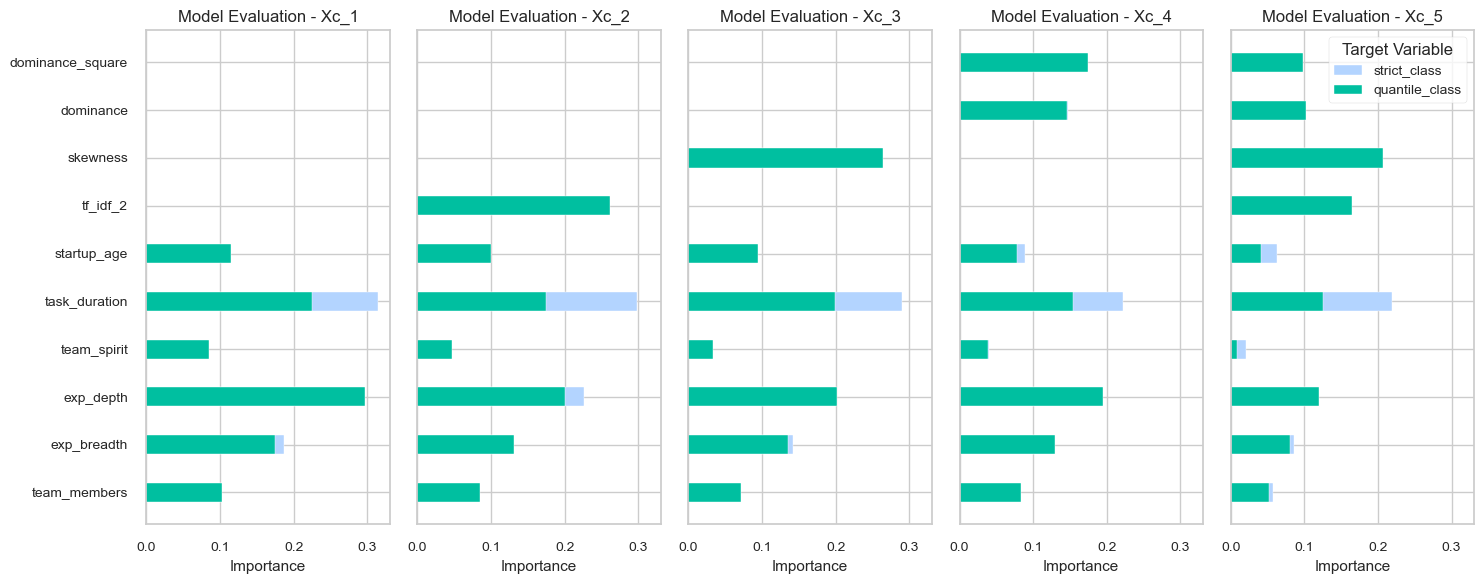

In [39]:
# Custom color palette
custom_palette = {'strict_class': '#b3d4ff', 'quantile_class': '#00bfa0'}

# Extract unique matrix names from the DataFrame
matrix_names = random_forest_importance['Matrix'].unique()

# Create subplots with shared y-axis
fig, axes = plt.subplots(ncols=len(matrix_names), nrows=1, figsize=(3 * len(matrix_names), 6), sharex=True, sharey=True)

# Iterate through matrix names
for idx, matrix_name in enumerate(matrix_names):
    # Filter the DataFrame for the current matrix and target variables
    matrix_df = random_forest_importance[random_forest_importance['Matrix'] == matrix_name]

    # Plot feature importances for strict class
    ax = axes[idx]
    strict_class_df = matrix_df[matrix_df['Target'] == 'strict_class']
    ax.barh(strict_class_df['Feature'], strict_class_df['Importance'], color=custom_palette['strict_class'], label='strict_class', height=0.4)

    # Plot feature importances for quantile class
    quantile_class_df = matrix_df[matrix_df['Target'] == 'quantile_class']
    ax.barh(quantile_class_df['Feature'], quantile_class_df['Importance'], color=custom_palette['quantile_class'], label='quantile_class', height=0.4)

    # Set axis labels and title
    ax.set_xlabel('Importance')
    ax.set_title(f'Model Evaluation - {matrix_name}')

# Adjust layout and show the plot
plt.legend(title='Target Variable', loc='upper right')
plt.tight_layout()
plt.show()


### Median Comparison for Interpretation

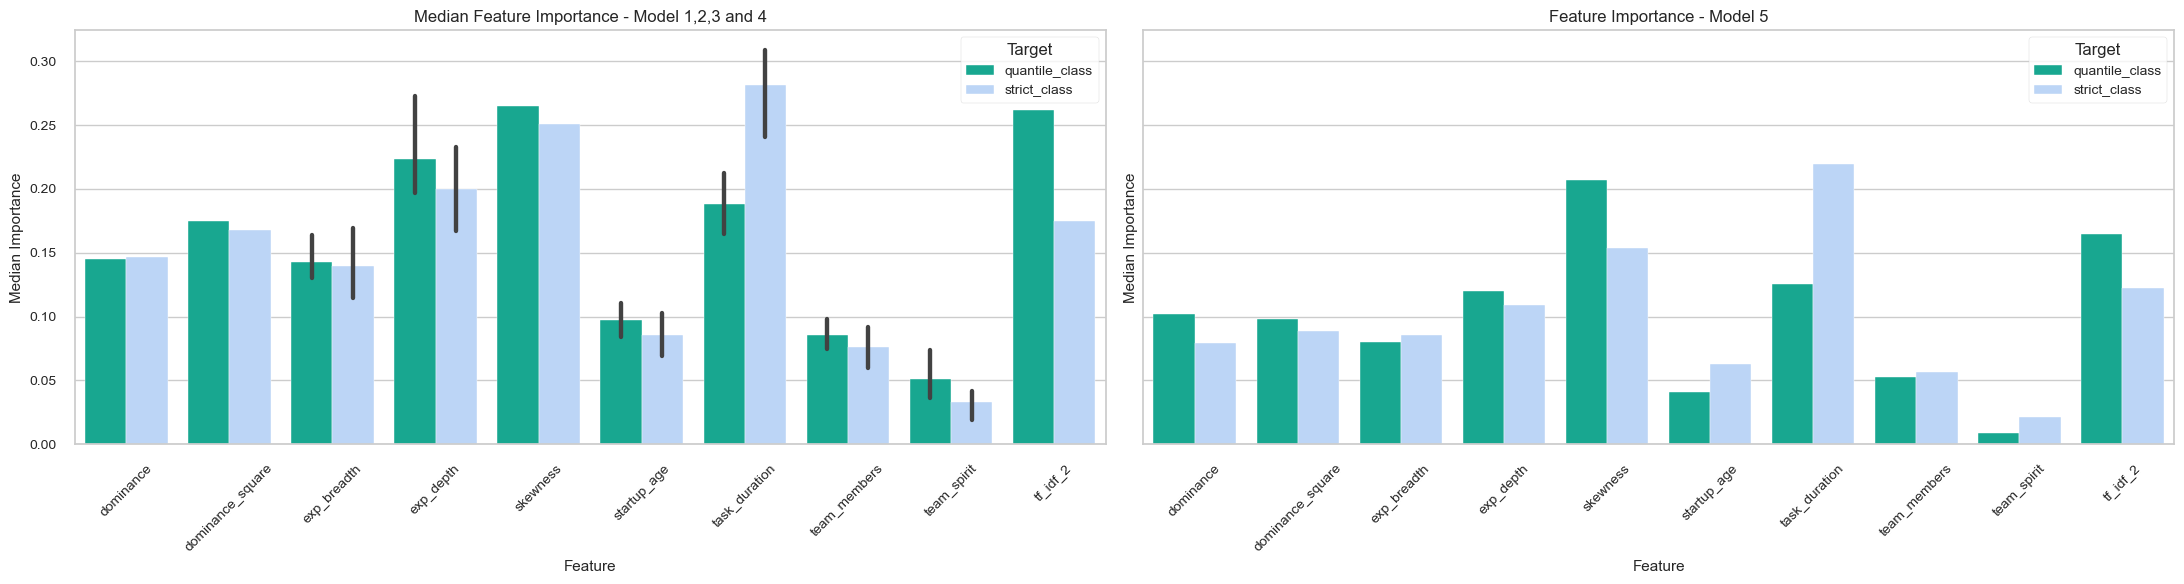

In [40]:
# Create a new DataFrame to store median importance scores
median_importance_df = random_forest_importance.groupby(['Feature', 'Target', 'Matrix'])['Importance'].median().reset_index()

# Filter the data for the first plot (Xc_1, Xc_2, Xc_3, Xc_4)
filtered_df1 = median_importance_df[median_importance_df['Matrix'].isin(['Xc_1', 'Xc_2', 'Xc_3', 'Xc_4'])]

# Filter the data for the second plot (Xc_5)
filtered_df2 = median_importance_df[median_importance_df['Matrix'] == 'Xc_5']

# Create subplots with shared y-axis
fig, axes = plt.subplots(ncols=2, figsize=(22, 6), sharey=True)

# Plot the median importance scores for Xc_1, Xc_2, Xc_3, and Xc_4 with custom colors
sns.barplot(x='Feature', y='Importance', hue='Target', data=filtered_df1, ax=axes[0], palette=custom_palette)
axes[0].set_title('Median Feature Importance - Model 1,2,3 and 4')
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Median Importance')
axes[0].tick_params(axis='x', rotation=45)  # Adjust x-axis labels for better visibility

# Plot the median importance scores for Xc_5 with custom colors
sns.barplot(x='Feature', y='Importance', hue='Target', data=filtered_df2, ax=axes[1], palette=custom_palette)
axes[1].set_title('Feature Importance - Model 5')
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Median Importance')
axes[1].tick_params(axis='x', rotation=45)  # Adjust x-axis labels for better visibility

# Adjust layout
plt.tight_layout()
plt.show()

## Appendix : Gaussian Mixture Model (GMM)

The objective of the following analysis was to explore potential clusters within the dataset based on different combinations of the news metrics `dominance`, `skewness`, and `tf_idf_2`. Gaussian Mixture Models (GMM) with three clusters were employed to identify patterns in the data. However, upon visualizing the results in 2D space for each combination of features (`dominance` vs `skewness`, `dominance` vs `tf_idf_2`, `skewness` vs `tf_idf_2`), no further analysis was conducted beyond the clustering, leaving the interpretation open for more in-depth investigation.

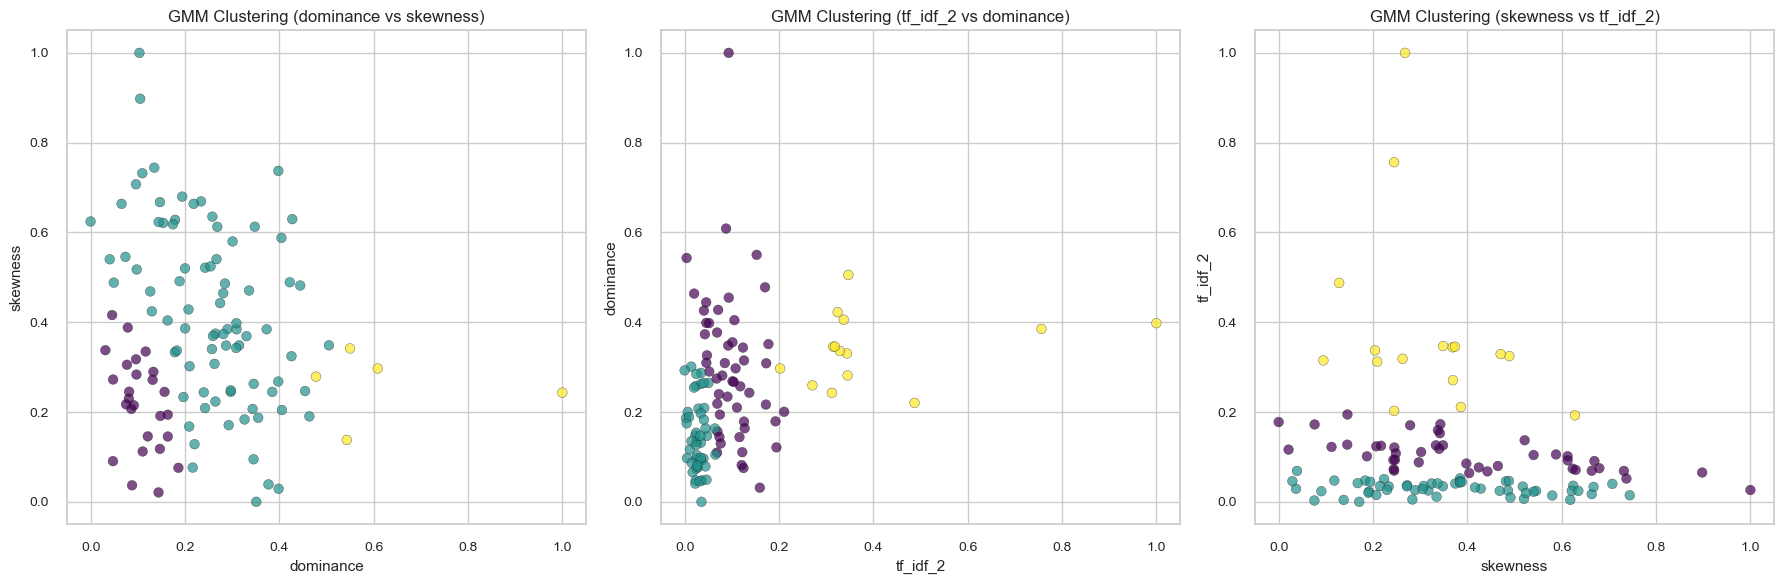

In [41]:
# Generate synthetic data
np.random.seed(42)

# Assuming df_final is your DataFrame
X = df_clean[['dominance', 'skewness', 'tf_idf_2']]

# List of feature combinations
feature_combinations = [('dominance', 'skewness'), ('tf_idf_2', 'dominance'), ('skewness', 'tf_idf_2')]

# Set up a 1x3 grid for subplots (one row, three columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Fit GMM model and plot for each feature combination
for i, (feature_x, feature_y) in enumerate(feature_combinations):
    # Select the features for the current combination
    X_2d = X[[feature_x, feature_y]]

    # Fit GMM model
    n_components = 3  # Number of components (clusters)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_2d)

    # Predict cluster labels
    labels = gmm.predict(X_2d)

    # Plot the clusters in 2D space with different colors and shapes
    axes[i].scatter(
        X_2d[feature_x],
        X_2d[feature_y],
        c=labels,
        cmap=plt.cm.get_cmap('viridis', n_components),
        marker='o',
        edgecolors='k',  # Add black edges for better visibility
        alpha=0.7
    )

    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)
    axes[i].set_title(f'GMM Clustering ({feature_x} vs {feature_y})')

plt.tight_layout()
plt.show()